In [1]:
import pandas as pd
import numpy as np
import scipy
from tqdm import tqdm_notebook, tqdm, trange
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed, dump, load
from Sparse_vector.sparse_vector import SparseVector
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]

In [72]:
# for chrom in tqdm_notebook(chroms):
#     for i in range((len(DeepZ[chrom]) // 25000000) + 1):
#         np.save(f'annotation/DeepZ/{chrom}_{i}', DeepZ[chrom][25000000 * i: 25000000 * i + 25000000])



In [3]:
%%time
files = {chrom:[] for chrom in chroms}

for file in sorted(os.listdir('annotation/DeepZ')):
    if file.startswith('.'):
        continue
    files[file.split('_')[0]].append(np.load(f'annotation/DeepZ/{file}'))
    
DeepZ = {chrom:np.concatenate(files[chrom]) for chrom in chroms}


CPU times: user 2.61 s, sys: 9.64 s, total: 12.2 s
Wall time: 14.3 s


In [4]:
zdna_df = pd.read_csv('annotation/ZDNA.bed', sep='\t', header=None)
zhunt_df = pd.read_csv('annotation/zhunt.bed', sep='\t', header=None)

In [5]:
ZDNA = {}
ZHUNT = {}



for chrom in tqdm_notebook(chroms):
    zdna = np.zeros_like(DeepZ[chrom]).astype(int)
    zhunt = np.zeros_like(DeepZ[chrom]).astype(int)
    
    for inter in zdna_df[zdna_df[0] == chrom].values:
        zdna[inter[1]:inter[2]+1] = 1
        
    for inter in zhunt_df[zhunt_df[0] == chrom].values:
        zhunt[inter[1]:inter[2]+1] = 1
    
    ZDNA[chrom] = SparseVector(zdna)
    ZHUNT[chrom] = SparseVector(zhunt)

In [11]:
genes = pd.read_csv('WholeGenes020219', sep='\t', header = None)[[0, 1, 2]].values

In [15]:
genes = zdna_df.values

In [16]:
genes[:, 1] = (genes[:, 1] // 5000) * 5000
genes[:, 2] = genes[:, 1] + 5000

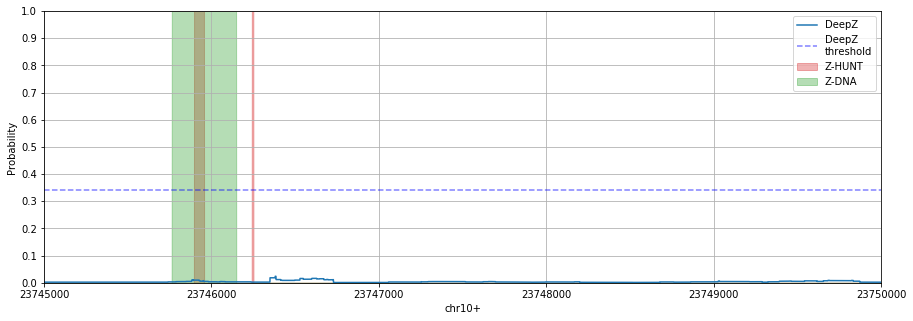

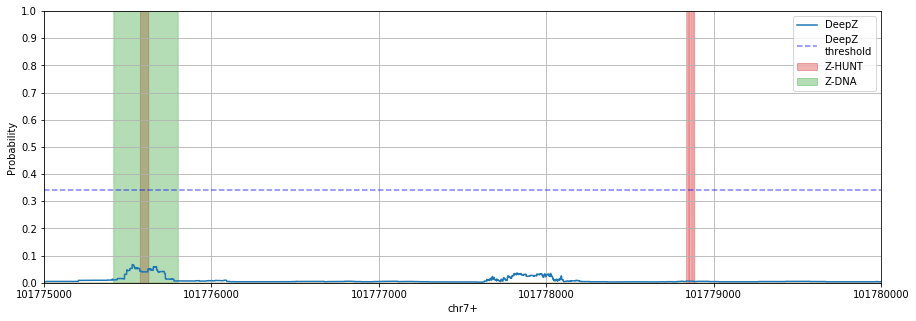

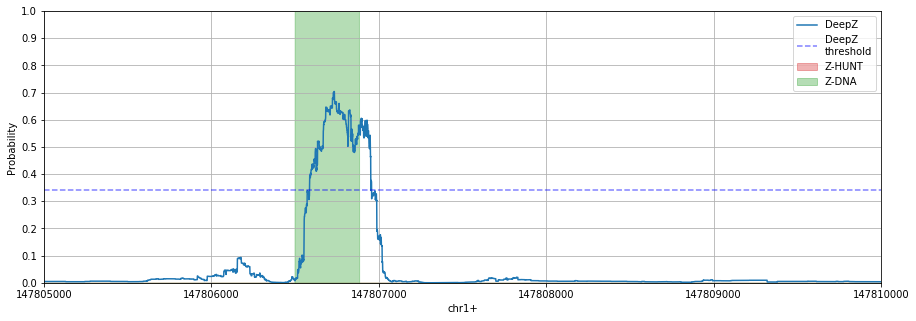

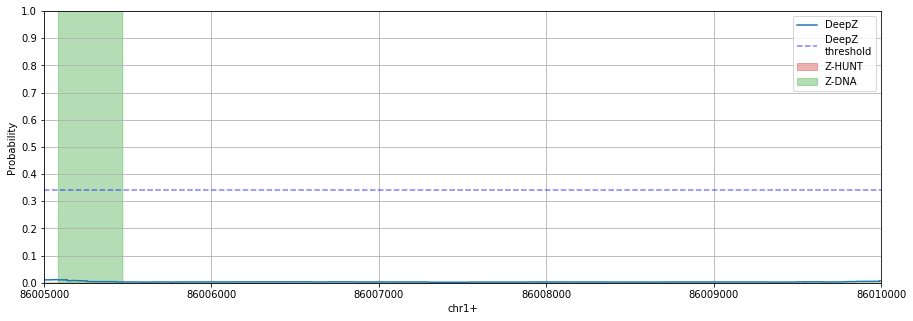

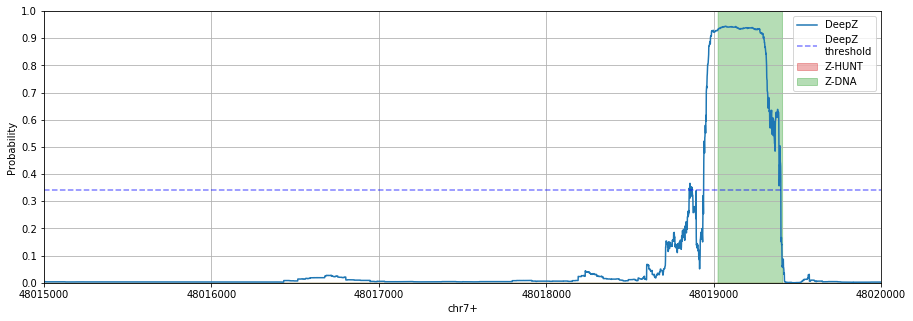

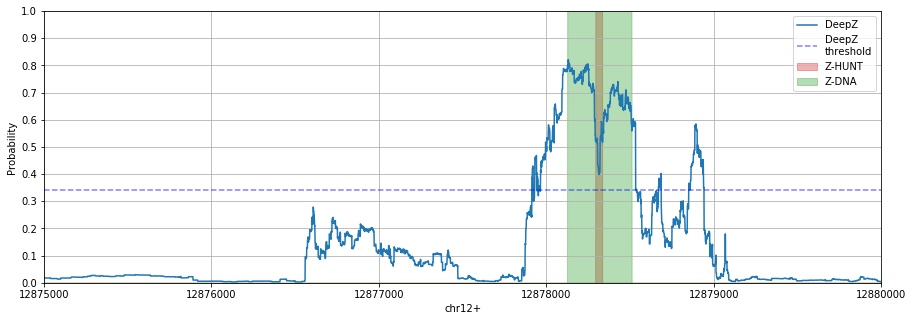

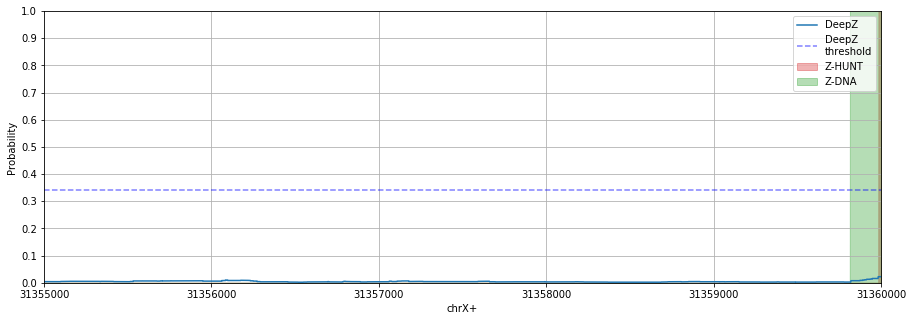

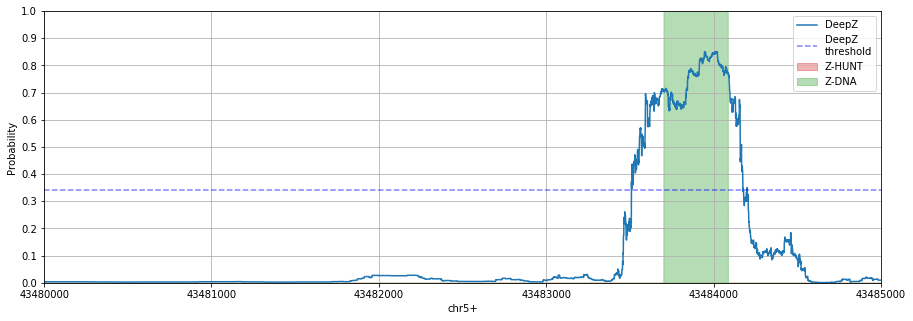

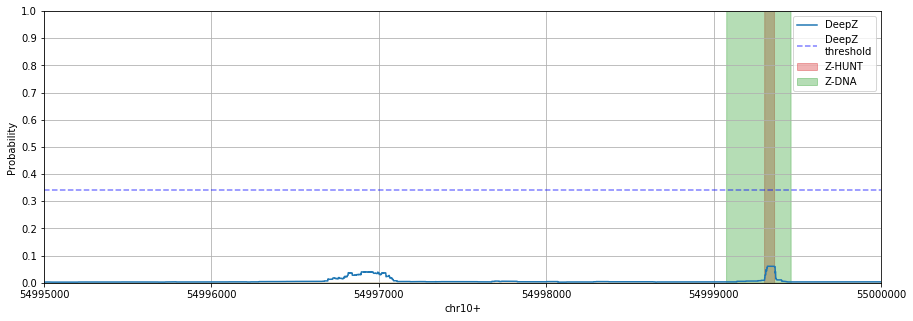

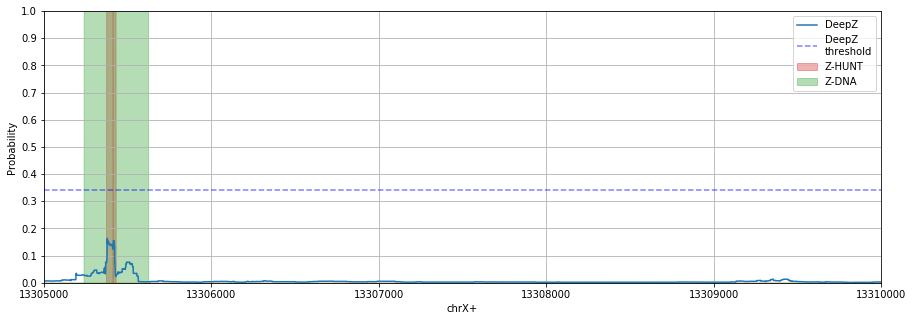

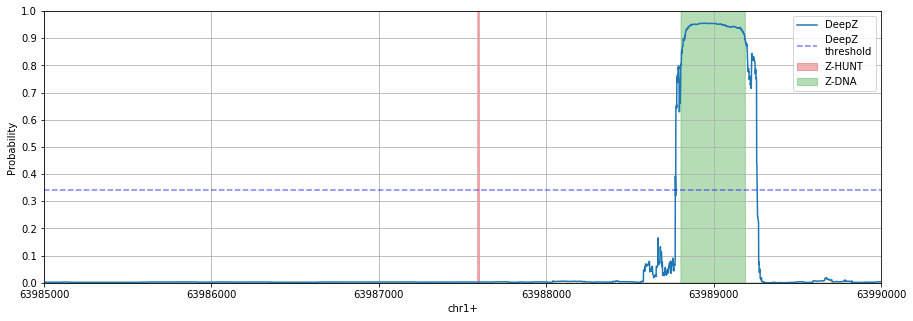

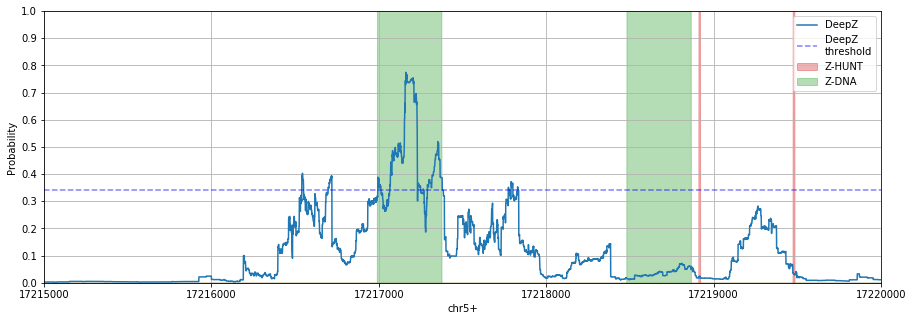

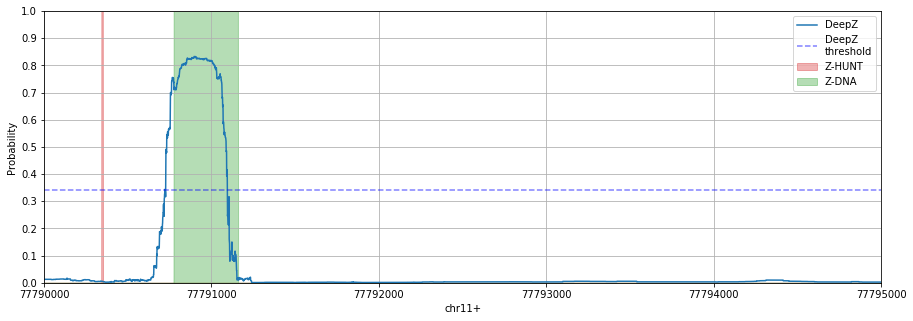

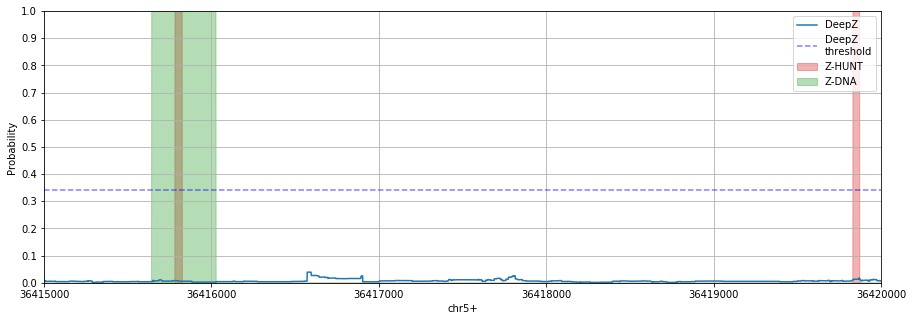

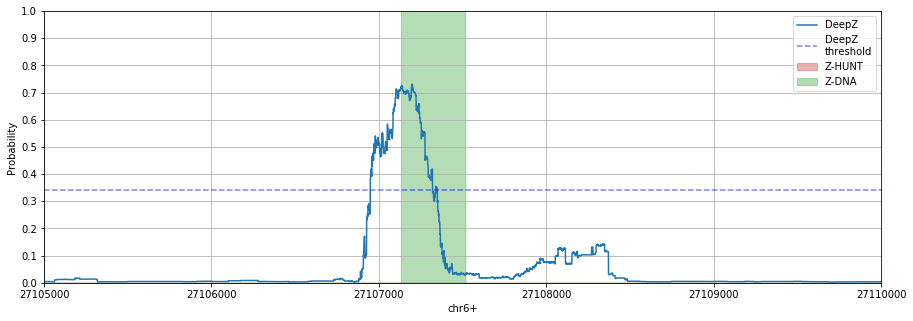

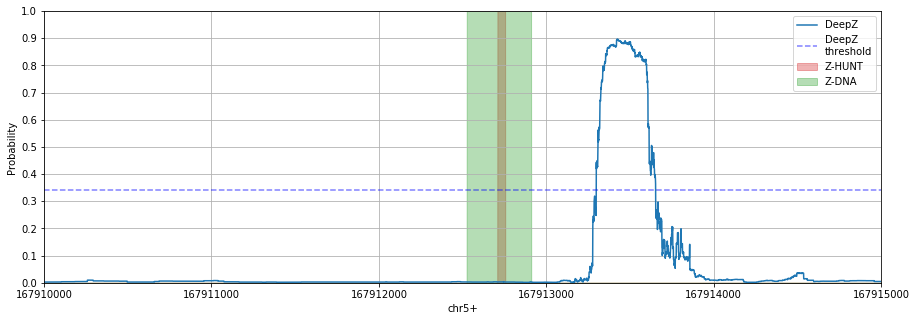

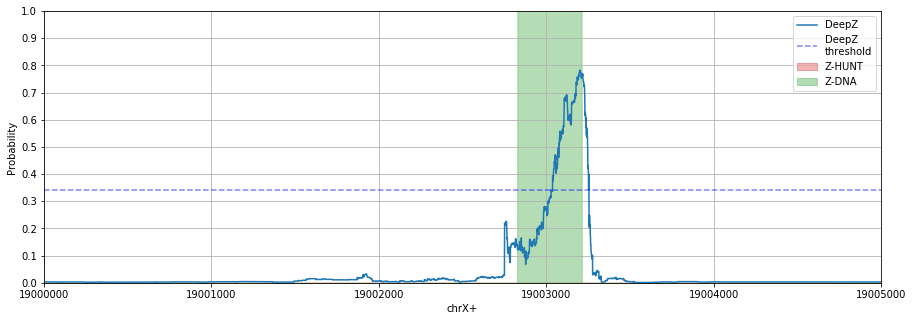

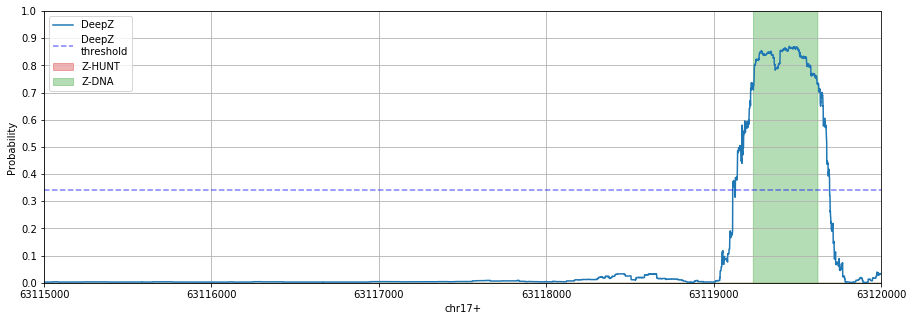

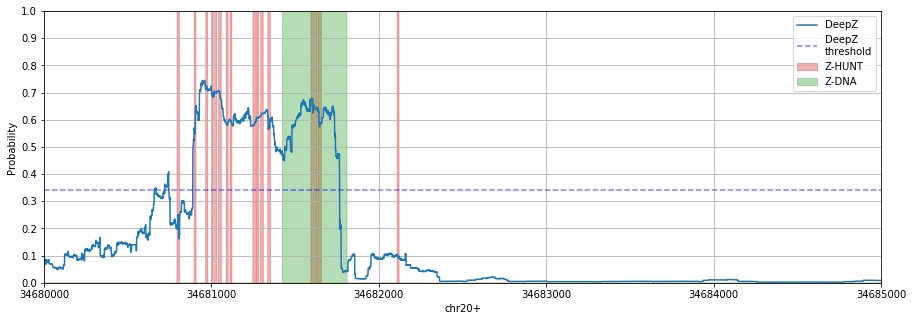

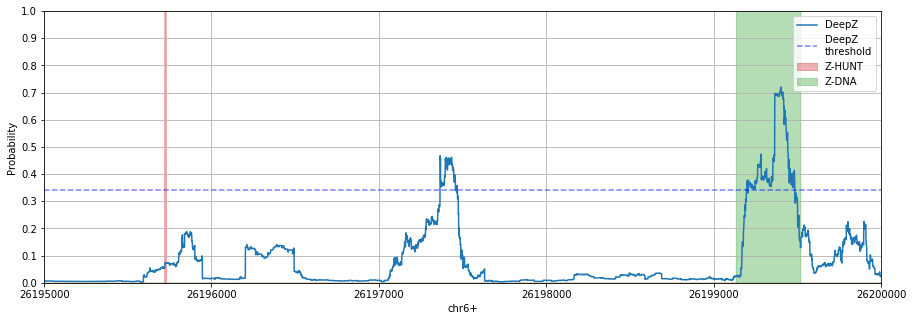

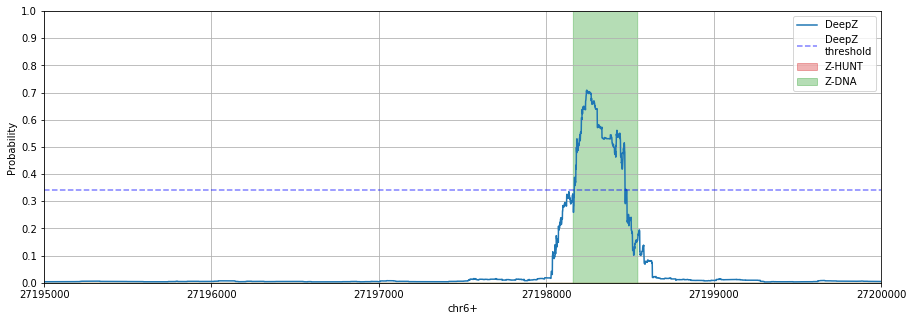

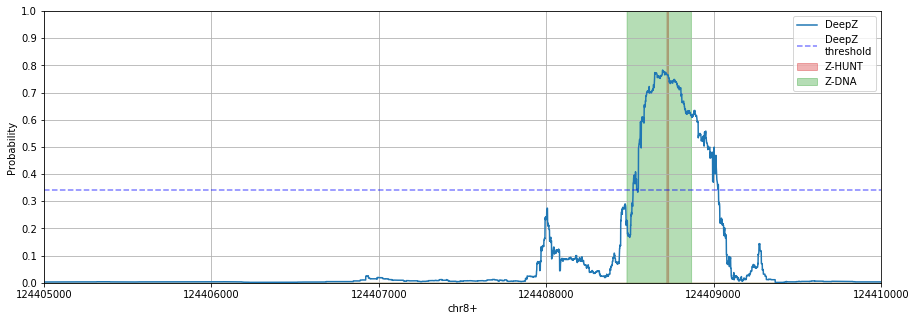

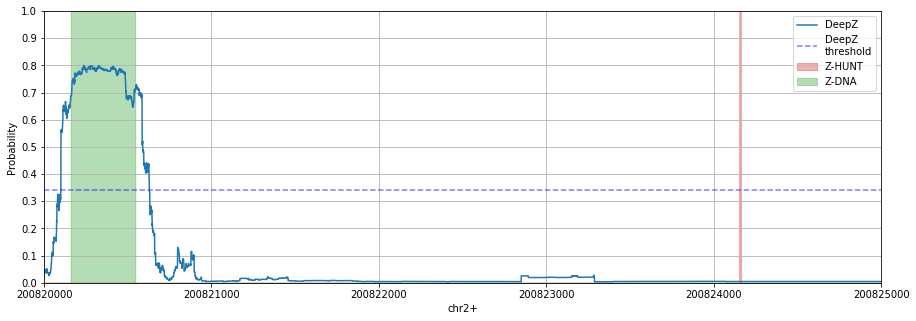

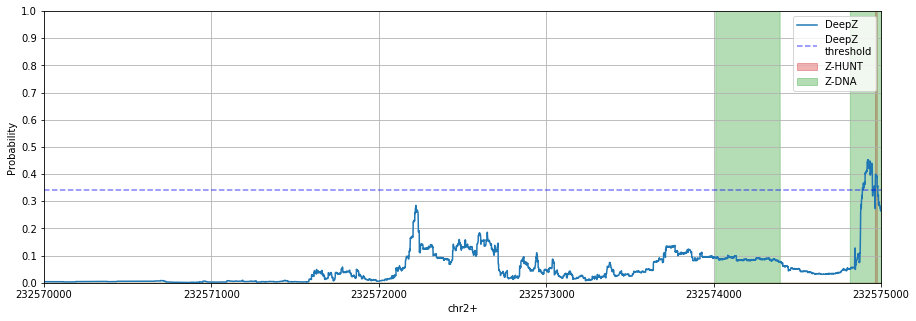

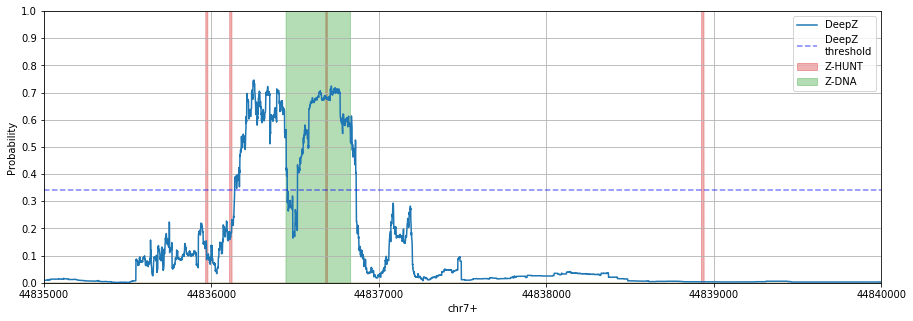

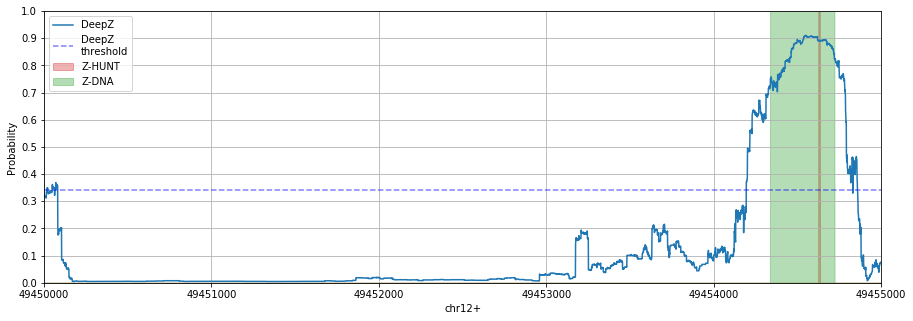

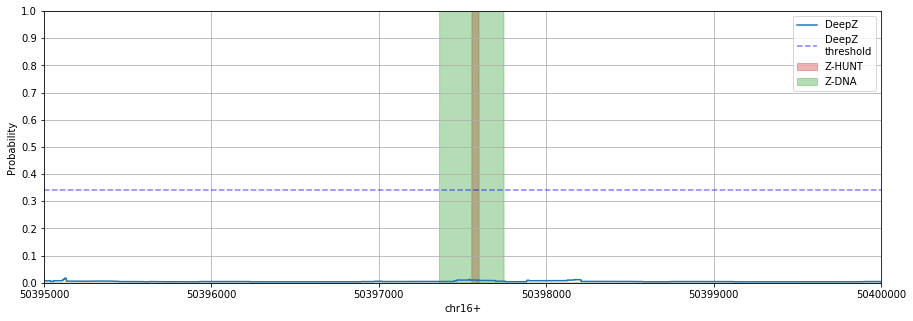

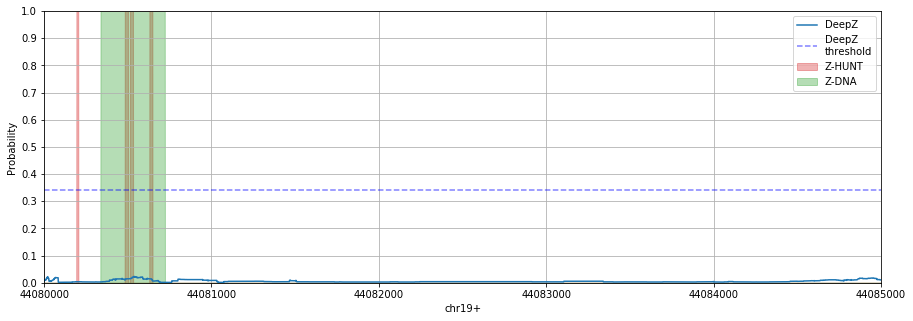

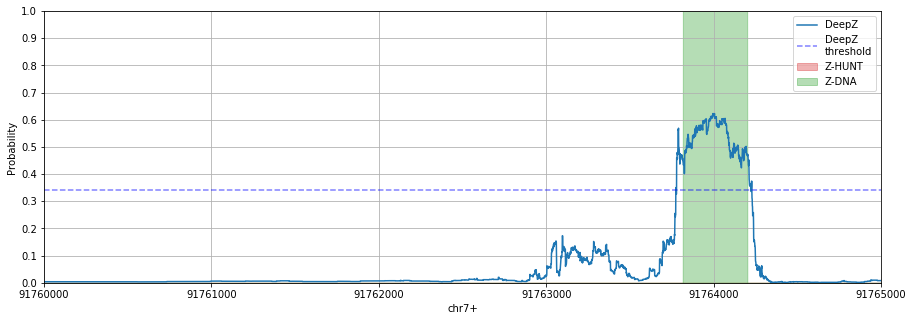

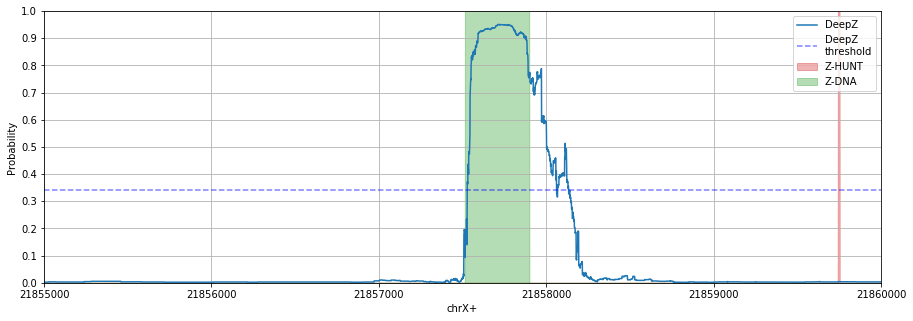

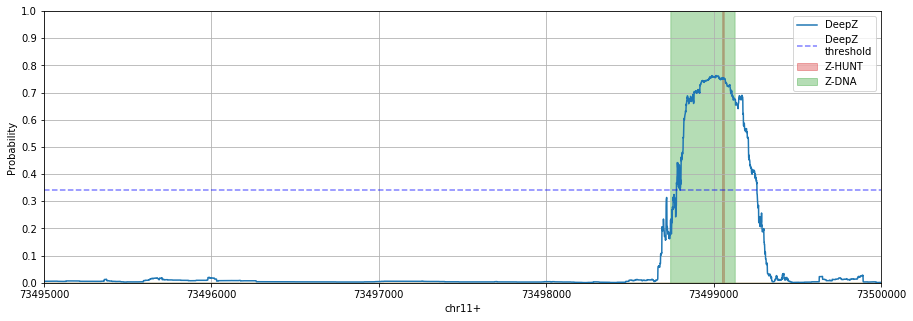

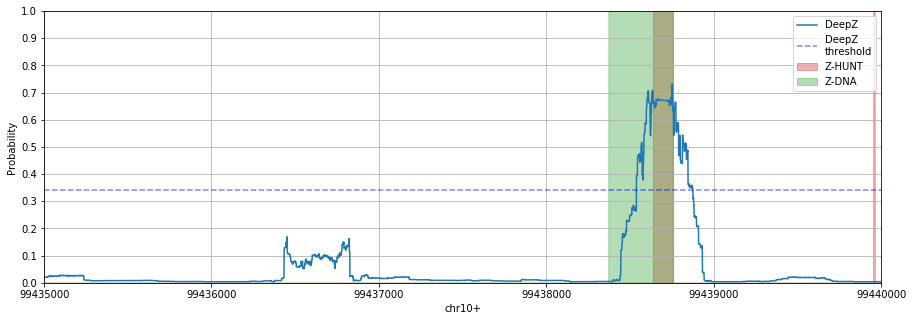

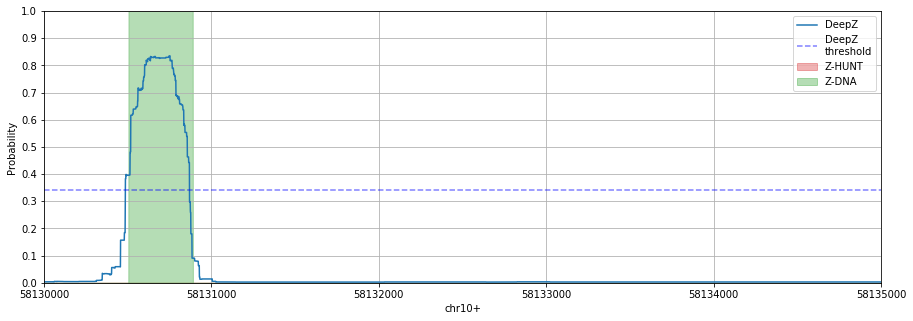

KeyboardInterrupt: 

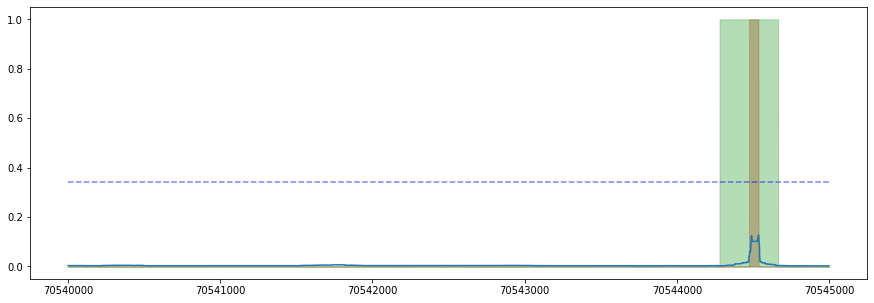

In [17]:
for inter, i in zip(tqdm_notebook(set([tuple(inter) for inter in genes if inter[0] in chroms])), range(100)):
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(inter[1], inter[2]),
             DeepZ[inter[0]][inter[1]: inter[2]], 
             label='DeepZ')
    
    plt.plot([inter[1], inter[2]], [0.343, 0.343], '--',
             label='DeepZ \nthreshold', alpha=0.5, color='b')
    
    plt.fill_between(np.arange(inter[1], inter[2]),
                     0,
                 ZHUNT[inter[0]][inter[1]:inter[2]],
                 label='Z-HUNT', color='C03', alpha=.35,)
    
    plt.fill_between(np.arange(inter[1], inter[2]),
                 0,
                 ZDNA[inter[0]][inter[1]:inter[2]],
                 label='Z-DNA', color='C02', alpha=.35,)  

    plt.xticks(np.arange(inter[1], inter[2]+1, 1000), 
               np.arange(inter[1], inter[2]+1, 1000))
    
    
    
    plt.xlabel(inter[0] + "+")
    plt.ylabel('Probability')
    plt.yticks(np.linspace(0, 1, 11))
    plt.xlim((inter[1], inter[2]))
    plt.ylim((0, 1))
    plt.grid()
    plt.legend()    
#     plt.savefig(f'images/{inter[0]}_{inter[1]}-{inter[2]}.png')
    plt.show()
#     break